# Project: COVID-19 Image Classification.

### **Objective:**

The aim of this project is to **Build a Convolutional Neural Network to differentiate an X-ray image of a person affected with covid from that of a healthy person or a person who has viral pneumonia(fever).**

### **Data Description:**

- This dataset contains training set images of 3 classes which are converted into numpy arrays. 
- The dataset comprises 3 classes: 
    - COVID-19: The patient who is effected due to covid.
    - Viral Pneumonia: This is a viral fever which has similar characteristics like fever and cought that of Covid but is not covid.
    - Normal- A healthy Person with no symptoms of covid or fever.
- The data file names are:
    - CovidImages.npy
    - CovidLabels.csv

## **Importing libraries**

In [1]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns

# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix

# Display images using OpenCV
from google.colab.patches import cv2_imshow                                                      # Importing cv2_imshow from google.patches to display images

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

**Load dataset and Summary**
- Read the dataset properly -Print the overview of the data (shape, checking the proportion of each class) - Plot the images from each class and print their corresponding labels.

## **Reading the dataset from my Google Drive**

In [2]:
# Mount Google drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load the images
images = np.load('/content/drive/MyDrive/covid/CovidImages.npy')

# Load the labels
labels = pd.read_csv('/content/drive/MyDrive/covid/CovidLabels.csv')

## **Dataset Overview**


In [4]:
# checking the shape of the dataset (images) and labels
print(images.shape)
print(labels.shape)

(251, 128, 128, 3)
(251, 1)


There are 251 RGB images, each image of shape 128 x 128 X 3.
The number of labels correspond with the number of files

<b>Converting BGR images to RGB for processing with OpenCV

In [5]:
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

**Perform an Exploratory Data Analysis on the images**
- Count Plot for each category - Any other exploratory deep dive

## **Exploratory Data Analysis** 

In [6]:
def plot_images(images,labels):
  num_classes=10                                                                  # Number of Classes
  categories=np.unique(labels)   
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 6                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image 
          ax.set_title(keys[random_index])
  plt.show()

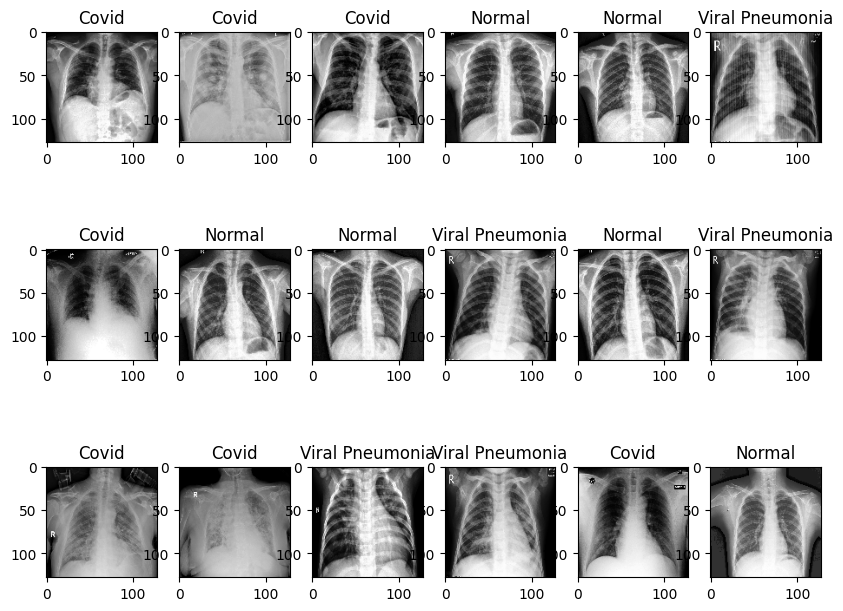

In [7]:
plot_images(images,labels)

In [8]:
# checking the balance of labels
labels['Label'].value_counts()

Covid              111
Viral Pneumonia     70
Normal              70
Name: Label, dtype: int64

The number of images for the covid category is bigger compared to the other two categories. 

**Data Pre - Processing**
-Try to remove unwanted noise from the images using Gaussian Blurring -Apply the normalization -Plot the images before and after the pre-processing steps -Split the data into train and test

### Resizing images 
A method to improve computational speed of the model is to reduce image size from 128 pixels to 64. However, it may also impact precission in certain details for classification. Let's give it a try

In [9]:
# creating loop to reduce pixel size of images
images_decreased=[]
height = 64
width = 64
dimensions = (width, height)  
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

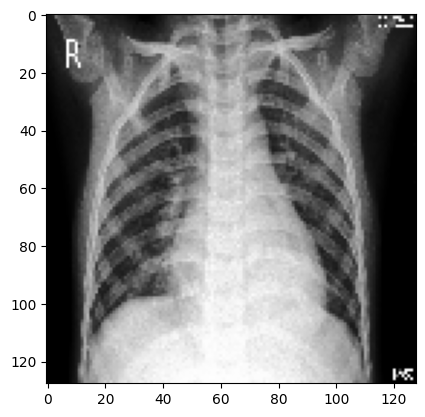

In [10]:
# image before reduction
plt.imshow(images[5])

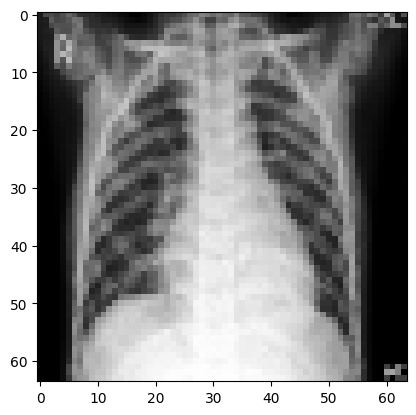

In [11]:
# image after reduction
plt.imshow(images_decreased[5])

**Illustrate the insights based on EDA**
-Key meaningful observations from EDA

it is obvius that reducing the pixel size, the quality of image is also reduced. 

## **Splitting the dataset**

- I will use 10% of our data for testing and 90% of our data for training, as we don't have many samples.


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(images_decreased),labels , test_size=0.1, random_state=42,stratify=labels)

In [13]:
# verifying shape of both training and test dataset
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(225, 64, 64, 3) (225, 1)
(26, 64, 64, 3) (26, 1)


**Make data compatible**
- Convert labels from digits to one hot vector. - Check the shape of the data. - Reshape the data into shapes compatible with Keras models, if already not compatible.

## Encoding the target labels

In [14]:
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_test_encoded=enc.transform(y_test)

In [15]:
enc.classes_

array(['Covid', 'Normal', 'Viral Pneumonia'], dtype='<U15')

In [16]:
y_train_encoded.shape, y_test_encoded.shape

((225, 3), (26, 3))

## Data Normalization


In [17]:
# Normalizing images for train and test datasets
X_train_normalized = X_train.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

**Model building**
- Build Convolution Neural Network - Use different layers in the model

## **Model Building - Convolutional Neural Network (CNN)**
Let's create a CNN model sequentially, where we will be adding the layers one after another.

In [18]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

Now, let's build a **CNN Model** with the following 2 main parts - <br>

1. **The Feature Extraction layers** which are comprised of convolutional and pooling layers.
2. **The Fully Connected classification layers** for prediction.<br>

In [19]:
# Intializing a sequential model
model1 = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 
model1.add(Conv2D(128, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))
# Adding max pooling to reduce the size of output of first conv layer
model1.add(MaxPooling2D((2, 2), padding = 'same'))

# Adding second conv layer with 64 filters and kernel size 3x3 and another max pooling
model1.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model1.add(Flatten())

# Adding a fully connected dense layer with 100 neurons    
model1.add(Dense(8, activation='relu'))
model1.add(Dropout(0.3))
# Adding the output layer with 3 neurons and activation functions as softmax since this is a multi-class classification problem  
model1.add(Dense(3, activation='softmax'))

opt=Adam()

# Compile model
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 8)                 1

### <b> Fitting the model on the train data

In [20]:
# fitting with 50 epochs
history_1 = model1.fit(
            X_train_normalized, y_train_encoded,
            epochs=50,
            validation_split=0.1,
            shuffle=False,
            batch_size=64,
            verbose=1
)

Epoch 1/50
4/4 [==============================] - 13s 685ms/step - loss: 1.1048 - accuracy: 0.3317 - val_loss: 1.0980 - val_accuracy: 0.4348
Epoch 2/50
4/4 [==============================] - 0s 36ms/step - loss: 1.1051 - accuracy: 0.3762 - val_loss: 1.0975 - val_accuracy: 0.4348
Epoch 3/50
4/4 [==============================] - 0s 33ms/step - loss: 1.0980 - accuracy: 0.4406 - val_loss: 1.0971 - val_accuracy: 0.4348
Epoch 4/50
4/4 [==============================] - 0s 32ms/step - loss: 1.0977 - accuracy: 0.4406 - val_loss: 1.0966 - val_accuracy: 0.4348
Epoch 5/50
4/4 [==============================] - 0s 28ms/step - loss: 1.0974 - accuracy: 0.4406 - val_loss: 1.0961 - val_accuracy: 0.4348
Epoch 6/50
4/4 [==============================] - 0s 26ms/step - loss: 1.0972 - accuracy: 0.4406 - val_loss: 1.0956 - val_accuracy: 0.4348
Epoch 7/50
4/4 [==============================] - 0s 28ms/step - loss: 1.0969 - accuracy: 0.4406 - val_loss: 1.0951 - val_accuracy: 0.4348
Epoch 8/50
4/4 [=========

Overall peformance `val_accuracy` looks very low. Let's now train with 100 epochs

In [21]:
# fitting with 100 epochs
history_2 = model1.fit(
            X_train_normalized, y_train_encoded,
            epochs=100,
            validation_split=0.1,
            shuffle=False,
            batch_size=64,
            verbose=1
)

Epoch 1/100
4/4 [==============================] - 0s 44ms/step - loss: 1.0885 - accuracy: 0.4406 - val_loss: 1.0809 - val_accuracy: 0.4348
Epoch 2/100
4/4 [==============================] - 0s 43ms/step - loss: 1.0883 - accuracy: 0.4406 - val_loss: 1.0807 - val_accuracy: 0.4348
Epoch 3/100
4/4 [==============================] - 0s 36ms/step - loss: 1.0882 - accuracy: 0.4406 - val_loss: 1.0805 - val_accuracy: 0.4348
Epoch 4/100
4/4 [==============================] - 0s 34ms/step - loss: 1.0881 - accuracy: 0.4406 - val_loss: 1.0803 - val_accuracy: 0.4348
Epoch 5/100
4/4 [==============================] - 0s 36ms/step - loss: 1.0880 - accuracy: 0.4406 - val_loss: 1.0801 - val_accuracy: 0.4348
Epoch 6/100
4/4 [==============================] - 0s 36ms/step - loss: 1.0879 - accuracy: 0.4406 - val_loss: 1.0800 - val_accuracy: 0.4348
Epoch 7/100
4/4 [==============================] - 0s 38ms/step - loss: 1.0878 - accuracy: 0.4406 - val_loss: 1.0798 - val_accuracy: 0.4348
Epoch 8/100
4/4 [===

Performance with 100 epochs is also very low. 

My impression is that after reducing the pixel size of the imanges **and** adding `maxpooling` to the first 2 layers is generalizing too much, and therefore not capturing the right values for a good prediction.

### **Model Evaluation**

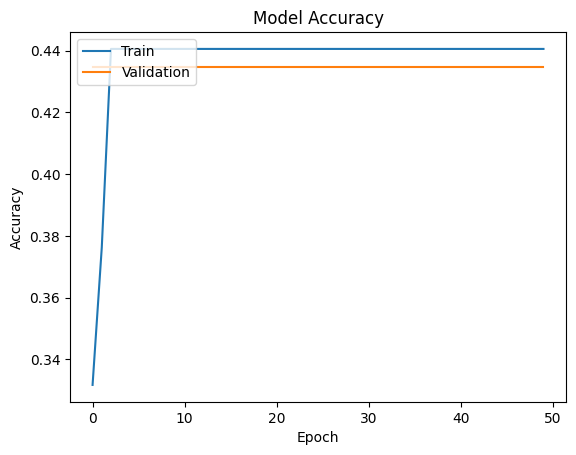

In [22]:
# evaluation of first fitting with 50 epochs
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

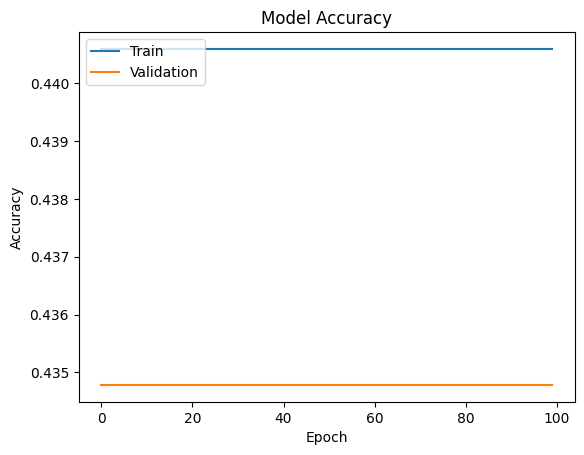

In [23]:
# evaluation of second fitting with 100 epochs
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Observations:** 
*   We can see from the above plot that **the training accuracy of the  model was not good and the validation accuracy was also not good.**
*   The shows that the model is not stable and not performing well. 
* Let's check the model performance on test set.





### **Evaluating the model on test data**

In [24]:
accuracy = model1.evaluate(X_test_normalized, y_test_encoded, verbose=2)

1/1 - 0s - loss: 1.0769 - accuracy: 0.4615 - 169ms/epoch - 169ms/step


**Model Performance Improvement**
- Comment on model performance - Can model performance be improved? check and comment - Build another model to implement these improvements Model Performance Improvement

Evaluation on test set is also poor. 

As we have a poor model even after doubling the epochs, let's create another CNN model but now without `maxpooling` as images are reduced. Let's see the performance.

In [25]:
# Intializing a sequential model
model2 = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 
model2.add(Conv2D(128, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding second conv layer with size 3x3
model2.add(Conv2D(64, (3, 3), activation='relu', padding="same"))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model2.add(Flatten())

# Adding a fully connected dense layer with 100 neurons    
model2.add(Dense(8, activation='relu'))
model2.add(Dropout(0.3))
# Adding the output layer with 3 neurons and activation functions as softmax since this is a multi-class classification problem  
model2.add(Dense(3, activation='softmax'))

opt=Adam()
# Compile model
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       3584      
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        73792     
                                                                 
 flatten_1 (Flatten)         (None, 262144)            0         
                                                                 
 dense_2 (Dense)             (None, 8)                 2097160   
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 3)                 27        
                                                                 
Total params: 2,174,563
Trainable params: 2,174,563
No

In [26]:
# fitting model2 with 50 epochs
history_3 = model2.fit(
            X_train_normalized, y_train_encoded,
            epochs=50,
            validation_split=0.1,
            shuffle=False,
            batch_size=64,
            verbose=1
)

Epoch 1/50
4/4 [==============================] - 4s 285ms/step - loss: 3.3120 - accuracy: 0.3317 - val_loss: 1.0980 - val_accuracy: 0.4348
Epoch 2/50
4/4 [==============================] - 0s 40ms/step - loss: 1.1098 - accuracy: 0.5297 - val_loss: 1.0749 - val_accuracy: 0.3913
Epoch 3/50
4/4 [==============================] - 0s 40ms/step - loss: 1.0325 - accuracy: 0.4901 - val_loss: 0.8888 - val_accuracy: 0.3913
Epoch 4/50
4/4 [==============================] - 0s 42ms/step - loss: 0.9154 - accuracy: 0.5743 - val_loss: 0.8109 - val_accuracy: 0.6522
Epoch 5/50
4/4 [==============================] - 0s 35ms/step - loss: 0.7412 - accuracy: 0.7129 - val_loss: 0.6302 - val_accuracy: 0.7826
Epoch 6/50
4/4 [==============================] - 0s 41ms/step - loss: 0.6408 - accuracy: 0.7525 - val_loss: 0.5316 - val_accuracy: 0.8261
Epoch 7/50
4/4 [==============================] - 0s 42ms/step - loss: 0.5858 - accuracy: 0.8861 - val_loss: 0.7958 - val_accuracy: 0.7826
Epoch 8/50
4/4 [==========

**Model Performance Evaluation**
-Evaluate the model on different performance metrics and comment on the performance and scope of improvement. For example precision, recall, accuracy. -Plot confusion matrix for all the models and comment on those.

The overall performance of `model2` has improved dramatically. Let's visualize and compare train and validation

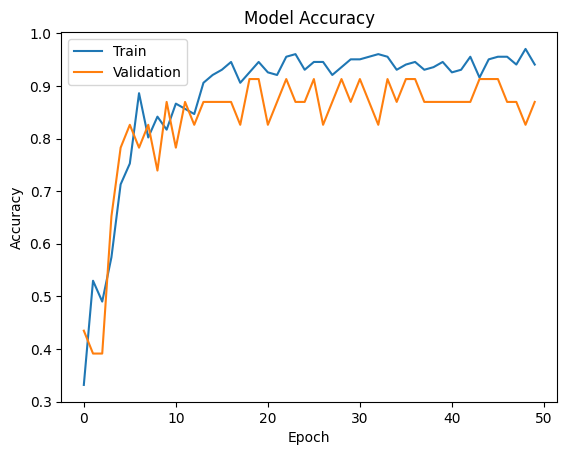

In [27]:
# visualizing results of model2 with 50 epochs
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [28]:
accuracy = model2.evaluate(X_test_normalized, y_test_encoded, verbose=2)

1/1 - 0s - loss: 0.0880 - accuracy: 0.9615 - 182ms/epoch - 182ms/step


### **Plotting the Confusion Matrix**




In [29]:
# Getting the output as probablities for each category
y_pred=model2.predict(X_test_normalized)

1/1 [==============================] - 0s 107ms/step


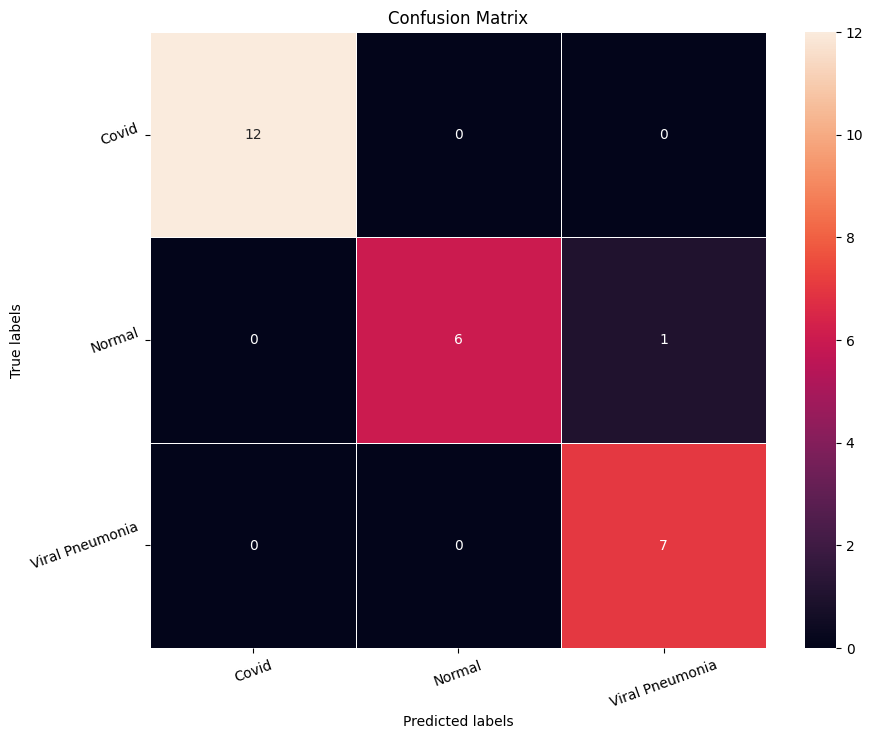

In [30]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Covid', 'Normal', 'Viral Pneumonia'],rotation=20)
ax.yaxis.set_ticklabels(['Covid', 'Normal', 'Viral Pneumonia'],rotation=20)
plt.show()

**Conclusion and key takeaways**
- Final conclusion about the analysis

- We observe that all classes are predicted correctly. 
- Reducing image pixel size impacts the quality of the dataset observation and in this particular case, adding maxpooling is not a good strategy. 